Table 2 - Case Ai

In [ ]:
from numpy.typing import ArrayLike
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf


"""
Input Parameters for the model - Case Ai
------------------------------
"""
# Ambient & initial plume conditions
Ta = 222.95            # Ambient temperature (K)
pa = 30230          # Ambient total pressure (Pa)
Ti = 563            # Initial temperature of the plume (K)
RHia = 0.65
pwa = Tf.p_sat_ice_murphy_koop(Ta) * RHia # Ambient water vapor pressure (Pa)
nAmbient = 0 # Ambient number concentration of aerosols (/m^3)

# Engine (and Mixing Line) Parameters 
N0 = 64.6             # Air to fuel ratio
EIsoot = 1.7 * 10**15 # Emission index of soot per fuel burned (/kg)
G = 1.59            # Mixing line slope (Pa/K)
tau = 0.005          # Characteristic mixing timescale (s)

# Aerosol properties
sigmaSoot = 1.7     # Standard deviation of a log-normal distribution for soot
sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
kSoot = 0.005       # Solubility parameter for soot
kAmbient = 0.5      # Solubility parameter for ambient aerosols
rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
rMeanSoot = 17 * 10**-9 # Mean dry soot radius (m)
rMeanAmbient = 15 * 10**-9 # Mean dry Ambient aerosol radius (m)
# Model resolution 
n = 1000000          # Number of points in the model

"""
Model Calculations
------------------------------
"""
# Temperature and time
T = np.geomspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
                                                # Note we assume isobaric expansion
time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

# Thermodynamic parameters
pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation vapor pressure of water (Pa)
nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)
rho = pa/(287 * T)    # Density of the plume as a function of temperature (kg/m^3)

# Mixing line parameters
Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line
dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)      

# Particle distribution parameters
zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols

rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsoot, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

# Microphysical parameters
nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

dSdt = Mf.supersaturation_forcing2(T=T, dTdt=dTdt, Smw=Smw) # Supersaturation forcing term in the microphysical model

tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

# Determine Final Results:
# - Pressure    - Float
# - RH(ambient) - Float     - pwa / pwSat(Ta)
# - RHi(ambient)- Float     - pwa / picesat(Ta)
# - Ta          - Float
# - Theta - T   - Float     - Need to find Phi
# - Phi         - Float     - Need to find Phi
# - ni          - Float     - intersection of nw1 and nw2
# - to          - Float     - time of intersection
# - ri          - Float     - ro at intersection
# - OD          - Float     - Optical depth at intersection -> Not calculated atm


# Clean up the data 

valid_indices = (smw >= 0)
timeV = time[valid_indices]
TV = T[valid_indices]

smwV = smw[valid_indices]
nw1V = nw1[valid_indices]
nw2V = nw2[valid_indices]
roV = ro[valid_indices]

nwSootV = nwSoot[valid_indices]
nwAmbientV = nwAmbient[valid_indices]
psiSootV = psiSoot[valid_indices]
psiAmbientV = psiAmbient[valid_indices]
DilutionV = Dilution[valid_indices]
rhoV = rho[valid_indices]


intercept = abs(nw1V - nw2V)
index2 = np.where(intercept == np.min(intercept))  # Find the index of the minimum difference

ro_intercept = roV[index2]
time_intercept = timeV[index2]
nw_intercept = nw1V[index2]
T_intercept = TV[index2]

nwSoot_intercept = nwSootV[index2]
nwAmbient_intercept = nwAmbientV[index2]
psiSoot_intercept = psiSootV[index2]
psiAmbient_intercept = psiAmbientV[index2]
Dilution_intercept = DilutionV[index2]
rho_intercept = rhoV[index2]

Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercept, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)


print(f"Sw_o: {Smw[index2]}")
print(f"pwo: {Smw[index2] * pwSat[index2]}")
print(f"pa: {pa}")
print(f"RH: {RH}")
print(f"RHi: {RHi}")
print(f"Ta: {Ta}")
print(f"thetaRH - Ta: {thetaRH - Ta}")
print(f"Phi: {Phi}")
print(f"ni (/cm^3): {nw_intercept * 10**-6}")
print(f"to: {time_intercept}")
print(f"ri (micrometres): {ro_intercept * 10**6}")
print(f"To (K): {T_intercept}")
print(f"AEIice: {AEIice}")


[6.84768762e+11 1.08534190e+12 1.30749773e+12 ... 2.16908638e+12
 1.72460668e+12 3.64998542e+11]
(array([7895]),)
Sw_o: [0.68470898]
pwo: [5.09982591]
pa: 30230
RH: 0.4046793246467679
RHi: 0.65
Ta: 222.95
thetaRH - Ta: 0.1345504448803183
Phi: [0.21505436]
ni (/cm^3): [60156.15105123]
to: [0.32587109]
ri (micrometres): [0.10420721]
To (K): [230.87272409]
AEIice: [3.6559242e+14]


Table 2 Case Aii

In [30]:
from numpy.typing import ArrayLike
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf


"""
Input Parameters for the model - Case Aii
------------------------------
"""
# Ambient & initial plume conditions
Ta = 222.95            # Ambient temperature (K)
pa = 30230          # Ambient total pressure (Pa)
Ti = 563            # Initial temperature of the plume (K)
RHia = 0.75
pwa = Tf.p_sat_ice_murphy_koop(Ta) * RHia # Ambient water vapor pressure (Pa)
nAmbient = 0 # Ambient number concentration of aerosols (/m^3)

# Engine (and Mixing Line) Parameters 
N0 = 64.6             # Air to fuel ratio
EIsoot = 1.7 * 10**15 # Emission index of soot per fuel burned (/kg)
G = 1.59            # Mixing line slope (Pa/K)
tau = 0.005          # Characteristic mixing timescale (s)

# Aerosol properties
sigmaSoot = 1.7     # Standard deviation of a log-normal distribution for soot
sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
kSoot = 0.005       # Solubility parameter for soot
kAmbient = 0.5      # Solubility parameter for ambient aerosols
rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
rMeanSoot = 17 * 10**-9 # Mean dry soot radius (m)
rMeanAmbient = 15 * 10**-9 # Mean dry Ambient aerosol radius (m)
# Model resolution 
n = 1000000          # Number of points in the model

"""
Model Calculations
------------------------------
"""
# Temperature and time
T = np.geomspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
                                                # Note we assume isobaric expansion
time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

# Thermodynamic parameters
pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation vapor pressure of water (Pa)
nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)
rho = pa/(287 * T)    # Density of the plume as a function of temperature (kg/m^3)

# Mixing line parameters
Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line
dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)      

# Particle distribution parameters
zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols

rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsoot, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

# Microphysical parameters
nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

dSdt = Mf.supersaturation_forcing2(T=T, dTdt=dTdt, Smw=Smw) # Supersaturation forcing term in the microphysical model

tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

# Determine Final Results:
# - Pressure    - Float
# - RH(ambient) - Float     - pwa / pwSat(Ta)
# - RHi(ambient)- Float     - pwa / picesat(Ta)
# - Ta          - Float
# - Theta - T   - Float     - Need to find Phi
# - Phi         - Float     - Need to find Phi
# - ni          - Float     - intersection of nw1 and nw2
# - to          - Float     - time of intersection
# - ri          - Float     - ro at intersection
# - OD          - Float     - Optical depth at intersection -> Not calculated atm


# Clean up the data 

valid_indices = (smw >= 0)
timeV = time[valid_indices]
TV = T[valid_indices]

smwV = smw[valid_indices]
nw1V = nw1[valid_indices]
nw2V = nw2[valid_indices]
roV = ro[valid_indices]

nwSootV = nwSoot[valid_indices]
nwAmbientV = nwAmbient[valid_indices]
psiSootV = psiSoot[valid_indices]
psiAmbientV = psiAmbient[valid_indices]
DilutionV = Dilution[valid_indices]
rhoV = rho[valid_indices]


intercept = abs(nw1V - nw2V)
index2 = np.where(intercept == np.min(intercept))[0]  # Find the index of the minimum difference
ro_intercept = roV[index2]
time_intercept = timeV[index2]
nw_intercept = nw1V[index2]
T_intercept = TV[index2]

nwSoot_intercept = nwSootV[index2]
nwAmbient_intercept = nwAmbientV[index2]
psiSoot_intercept = psiSootV[index2]
psiAmbient_intercept = psiAmbientV[index2]
Dilution_intercept = DilutionV[index2]
rho_intercept = rhoV[index2]

Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercept, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)


print(f"Sw_o: {Smw[index2]}")
print(f"pwo: {Smw[index2] * pwSat[index2]}")
print(f"pa: {pa}")
print(f"RH: {RH}")
print(f"RHi: {RHi}")
print(f"Ta: {Ta}")
print(f"thetaRH - Ta: {thetaRH - Ta}")
print(f"Phi: {Phi}")
print(f"ni (/cm^3): {nw_intercept * 10**-6}")
print(f"to: {time_intercept}")
print(f"ri (micrometres): {ro_intercept * 10**6}")
print(f"To (K): {T_intercept}")
print(f"AEIice: {AEIice}")


Sw_o: [0.89815814]
pwo: [7.99429152]
pa: 30230
RH: 0.46693768228473226
RHi: 0.75
Ta: 222.95
thetaRH - Ta: 0.3762332803275399
Phi: [0.65540466]
ni (/cm^3): [192381.63081679]
to: [0.30828456]
ri (micrometres): [0.09184254]
To (K): [231.27835424]
AEIice: [1.11418793e+15]


Table 2 Case Aiii

In [31]:
from numpy.typing import ArrayLike
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf


"""
Input Parameters for the model - Case Aiii
------------------------------
"""
# Ambient & initial plume conditions
Ta = 222.45            # Ambient temperature (K)
pa = 30230          # Ambient total pressure (Pa)
Ti = 563            # Initial temperature of the plume (K)
RHia = 0.65
pwa = Tf.p_sat_ice_murphy_koop(Ta) * RHia # Ambient water vapor pressure (Pa)
nAmbient = 0 # Ambient number concentration of aerosols (/m^3)

# Engine (and Mixing Line) Parameters 
N0 = 64.6             # Air to fuel ratio
EIsoot = 1.7 * 10**15 # Emission index of soot per fuel burned (/kg)
G = 1.59            # Mixing line slope (Pa/K)
tau = 0.005          # Characteristic mixing timescale (s)

# Aerosol properties
sigmaSoot = 1.7     # Standard deviation of a log-normal distribution for soot
sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
kSoot = 0.005       # Solubility parameter for soot
kAmbient = 0.5      # Solubility parameter for ambient aerosols
rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
rMeanSoot = 17 * 10**-9 # Mean dry soot radius (m)
rMeanAmbient = 15 * 10**-9 # Mean dry Ambient aerosol radius (m)
# Model resolution 
n = 1000000          # Number of points in the model

"""
Model Calculations
------------------------------
"""
# Temperature and time
T = np.geomspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
                                                # Note we assume isobaric expansion
time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

# Thermodynamic parameters
pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation vapor pressure of water (Pa)
nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)
rho = pa/(287 * T)    # Density of the plume as a function of temperature (kg/m^3)

# Mixing line parameters
Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line
dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)      

# Particle distribution parameters
zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols

rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsoot, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

# Microphysical parameters
nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

dSdt = Mf.supersaturation_forcing2(T=T, dTdt=dTdt, Smw=Smw) # Supersaturation forcing term in the microphysical model

tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

# Determine Final Results:
# - Pressure    - Float
# - RH(ambient) - Float     - pwa / pwSat(Ta)
# - RHi(ambient)- Float     - pwa / picesat(Ta)
# - Ta          - Float
# - Theta - T   - Float     - Need to find Phi
# - Phi         - Float     - Need to find Phi
# - ni          - Float     - intersection of nw1 and nw2
# - to          - Float     - time of intersection
# - ri          - Float     - ro at intersection
# - OD          - Float     - Optical depth at intersection -> Not calculated atm


# Clean up the data 

valid_indices = (smw >= 0)
timeV = time[valid_indices]
TV = T[valid_indices]

smwV = smw[valid_indices]
nw1V = nw1[valid_indices]
nw2V = nw2[valid_indices]
roV = ro[valid_indices]

nwSootV = nwSoot[valid_indices]
nwAmbientV = nwAmbient[valid_indices]
psiSootV = psiSoot[valid_indices]
psiAmbientV = psiAmbient[valid_indices]
DilutionV = Dilution[valid_indices]
rhoV = rho[valid_indices]


intercept = abs(nw1V - nw2V)
index2 = np.where(intercept == np.min(intercept))[0]  # Find the index of the minimum difference
ro_intercept = roV[index2]
time_intercept = timeV[index2]
nw_intercept = nw1V[index2]
T_intercept = TV[index2]

nwSoot_intercept = nwSootV[index2]
nwAmbient_intercept = nwAmbientV[index2]
psiSoot_intercept = psiSootV[index2]
psiAmbient_intercept = psiAmbientV[index2]
Dilution_intercept = DilutionV[index2]
rho_intercept = rhoV[index2]

Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercept, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)


print(f"Sw_o: {Smw[index2]}")
print(f"pwo: {Smw[index2] * pwSat[index2]}")
print(f"pa: {pa}")
print(f"RH: {RH}")
print(f"RHi: {RHi}")
print(f"Ta: {Ta}")
print(f"thetaRH - Ta: {thetaRH - Ta}")
print(f"Phi: {Phi}")
print(f"ni (/cm^3): {nw_intercept * 10**-6}")
print(f"to: {time_intercept}")
print(f"ri (micrometres): {ro_intercept * 10**6}")
print(f"To (K): {T_intercept}")
print(f"AEIice: {AEIice}")




Sw_o: [0.9530532]
pwo: [8.8368853]
pa: 30230
RH: 0.40309931902477125
RHi: 0.65
Ta: 222.45
thetaRH - Ta: 0.5401321823779313
Phi: [0.78019047]
ni (/cm^3): [249708.13542532]
to: [0.27965394]
ri (micrometres): [0.0923574]
To (K): [231.55531638]
AEIice: [1.32632379e+15]


Table 2 - Case Aiv

In [33]:
from numpy.typing import ArrayLike
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf


"""
Input Parameters for the model - Case Aiv
------------------------------
"""
# Ambient & initial plume conditions
Ta = 222.45            # Ambient temperature (K)
pa = 30230          # Ambient total pressure (Pa)
Ti = 563            # Initial temperature of the plume (K)
RHia = 0.75
pwa = Tf.p_sat_ice_murphy_koop(Ta) * RHia # Ambient water vapor pressure (Pa)
nAmbient = 0 # Ambient number concentration of aerosols (/m^3)

# Engine (and Mixing Line) Parameters 
N0 = 64.6             # Air to fuel ratio
EIsoot = 1.7 * 10**15 # Emission index of soot per fuel burned (/kg)
G = 1.59            # Mixing line slope (Pa/K)
tau = 0.005          # Characteristic mixing timescale (s)

# Aerosol properties
sigmaSoot = 1.7     # Standard deviation of a log-normal distribution for soot
sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
kSoot = 0.005       # Solubility parameter for soot
kAmbient = 0.5      # Solubility parameter for ambient aerosols
rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
rMeanSoot = 17 * 10**-9 # Mean dry soot radius (m)
rMeanAmbient = 15 * 10**-9 # Mean dry Ambient aerosol radius (m)
# Model resolution 
n = 1000000          # Number of points in the model

"""
Model Calculations
------------------------------
"""
# Temperature and time
T = np.geomspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
                                                # Note we assume isobaric expansion
time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

# Thermodynamic parameters
pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation vapor pressure of water (Pa)
nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)
rho = pa/(287 * T)    # Density of the plume as a function of temperature (kg/m^3)

# Mixing line parameters
Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line
dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)      

# Particle distribution parameters
zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols

rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsoot, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

# Microphysical parameters
nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

dSdt = Mf.supersaturation_forcing2(T=T, dTdt=dTdt, Smw=Smw) # Supersaturation forcing term in the microphysical model

tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

# Determine Final Results:
# - Pressure    - Float
# - RH(ambient) - Float     - pwa / pwSat(Ta)
# - RHi(ambient)- Float     - pwa / picesat(Ta)
# - Ta          - Float
# - Theta - T   - Float     - Need to find Phi
# - Phi         - Float     - Need to find Phi
# - ni          - Float     - intersection of nw1 and nw2
# - to          - Float     - time of intersection
# - ri          - Float     - ro at intersection
# - OD          - Float     - Optical depth at intersection -> Not calculated atm


# Clean up the data 

valid_indices = (smw >= 0)
timeV = time[valid_indices]
TV = T[valid_indices]

smwV = smw[valid_indices]
nw1V = nw1[valid_indices]
nw2V = nw2[valid_indices]
roV = ro[valid_indices]

nwSootV = nwSoot[valid_indices]
nwAmbientV = nwAmbient[valid_indices]
psiSootV = psiSoot[valid_indices]
psiAmbientV = psiAmbient[valid_indices]
DilutionV = Dilution[valid_indices]
rhoV = rho[valid_indices]


intercept = abs(nw1V - nw2V)
index2 = np.where(intercept == np.min(intercept))[0]  # Find the index of the minimum difference
ro_intercept = roV[index2]
time_intercept = timeV[index2]
nw_intercept = nw1V[index2]
T_intercept = TV[index2]

nwSoot_intercept = nwSootV[index2]
nwAmbient_intercept = nwAmbientV[index2]
psiSoot_intercept = psiSootV[index2]
psiAmbient_intercept = psiAmbientV[index2]
Dilution_intercept = DilutionV[index2]
rho_intercept = rhoV[index2]

Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercept, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)


print(f"Sw_o: {Smw[index2]}")
print(f"pwo: {Smw[index2] * pwSat[index2]}")
print(f"pa: {pa}")
print(f"RH: {RH}")
print(f"RHi: {RHi}")
print(f"Ta: {Ta}")
print(f"thetaRH - Ta: {thetaRH - Ta}")
print(f"Phi: {Phi}")
print(f"ni (/cm^3): {nw_intercept * 10**-6}")
print(f"to: {time_intercept}")
print(f"ri (micrometres): {ro_intercept * 10**6}")
print(f"To (K): {T_intercept}")
print(f"AEIice: {AEIice}")


Sw_o: [1.04751166]
pwo: [11.0520476]
pa: 30230
RH: 0.46511459887473605
RHi: 0.75
Ta: 222.45
thetaRH - Ta: 0.7672891312863044
Phi: [0.85644671]
ni (/cm^3): [287328.52024831]
to: [0.26481935]
ri (micrometres): [0.09602144]
To (K): [232.01310995]
AEIice: [1.4559594e+15]


Table 2 - Case Av

In [34]:
from numpy.typing import ArrayLike
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf


"""
Input Parameters for the model - Case Av
------------------------------
"""
# Ambient & initial plume conditions
Ta = 220.70            # Ambient temperature (K)
pa = 28740          # Ambient total pressure (Pa)
Ti = 563            # Initial temperature of the plume (K)
RHia = 0.73
pwa = Tf.p_sat_ice_murphy_koop(Ta) * RHia # Ambient water vapor pressure (Pa)
nAmbient = 0 # Ambient number concentration of aerosols (/m^3)

# Engine (and Mixing Line) Parameters 
N0 = 64.6             # Air to fuel ratio
EIsoot = 1.7 * 10**15 # Emission index of soot per fuel burned (/kg)
G = 1.59            # Mixing line slope (Pa/K)
tau = 0.005          # Characteristic mixing timescale (s)

# Aerosol properties
sigmaSoot = 1.7     # Standard deviation of a log-normal distribution for soot
sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
kSoot = 0.005       # Solubility parameter for soot
kAmbient = 0.5      # Solubility parameter for ambient aerosols
rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
rMeanSoot = 17 * 10**-9 # Mean dry soot radius (m)
rMeanAmbient = 15 * 10**-9 # Mean dry Ambient aerosol radius (m)
# Model resolution 
n = 1000000          # Number of points in the model

"""
Model Calculations
------------------------------
"""
# Temperature and time
T = np.geomspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
                                                # Note we assume isobaric expansion
time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

# Thermodynamic parameters
pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation vapor pressure of water (Pa)
nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)
rho = pa/(287 * T)    # Density of the plume as a function of temperature (kg/m^3)

# Mixing line parameters
Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line
dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)      

# Particle distribution parameters
zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols

rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsoot, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

# Microphysical parameters
nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

dSdt = Mf.supersaturation_forcing2(T=T, dTdt=dTdt, Smw=Smw) # Supersaturation forcing term in the microphysical model

tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

# Determine Final Results:
# - Pressure    - Float
# - RH(ambient) - Float     - pwa / pwSat(Ta)
# - RHi(ambient)- Float     - pwa / picesat(Ta)
# - Ta          - Float
# - Theta - T   - Float     - Need to find Phi
# - Phi         - Float     - Need to find Phi
# - ni          - Float     - intersection of nw1 and nw2
# - to          - Float     - time of intersection
# - ri          - Float     - ro at intersection
# - OD          - Float     - Optical depth at intersection -> Not calculated atm


# Clean up the data 

valid_indices = (smw >= 0)
timeV = time[valid_indices]
TV = T[valid_indices]

smwV = smw[valid_indices]
nw1V = nw1[valid_indices]
nw2V = nw2[valid_indices]
roV = ro[valid_indices]

nwSootV = nwSoot[valid_indices]
nwAmbientV = nwAmbient[valid_indices]
psiSootV = psiSoot[valid_indices]
psiAmbientV = psiAmbient[valid_indices]
DilutionV = Dilution[valid_indices]
rhoV = rho[valid_indices]


intercept = abs(nw1V - nw2V)
index2 = np.where(intercept == np.min(intercept))[0]  # Find the index of the minimum difference
ro_intercept = roV[index2]
time_intercept = timeV[index2]
nw_intercept = nw1V[index2]
T_intercept = TV[index2]

nwSoot_intercept = nwSootV[index2]
nwAmbient_intercept = nwAmbientV[index2]
psiSoot_intercept = psiSootV[index2]
psiAmbient_intercept = psiAmbientV[index2]
Dilution_intercept = DilutionV[index2]
rho_intercept = rhoV[index2]

Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercept, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)


print(f"Sw_o: {Smw[index2]}")
print(f"pwo: {Smw[index2] * pwSat[index2]}")
print(f"pa: {pa}")
print(f"RH: {RH}")
print(f"RHi: {RHi}")
print(f"Ta: {Ta}")
print(f"thetaRH - Ta: {thetaRH - Ta}")
print(f"Phi: {Phi}")
print(f"ni (/cm^3): {nw_intercept * 10**-6}")
print(f"to: {time_intercept}")
print(f"ri (micrometres): {ro_intercept * 10**6}")
print(f"To (K): {T_intercept}")
print(f"AEIice: {AEIice}")


Sw_o: [1.23165759]
pwo: [18.13187253]
pa: 28740
RH: 0.44668492116721115
RHi: 0.73
Ta: 220.7
thetaRH - Ta: 2.1455201658906446
Phi: [0.96207384]
ni (/cm^3): [412276.51556147]
to: [0.18920474]
ri (micrometres): [0.11103158]
To (K): [233.70891578]
AEIice: [1.63552552e+15]


Table 2 - Case B

In [41]:
from numpy.typing import ArrayLike
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

import Thermodynamic_funcs as Tf
import Mixing_line_funcs as Mf
import Microphysical_funcs as Mpf
import Particle_distribution_funcs as PDf


"""
Input Parameters for the model - Case Aiii
------------------------------
"""
# Ambient & initial plume conditions
Ta = 220            # Ambient temperature (K)
pa = 25000          # Ambient total pressure (Pa)
Ti = 600            # Initial temperature of the plume (K)
RHia = 1
pwa = Tf.p_sat_ice_murphy_koop(Ta) * RHia # Ambient water vapor pressure (Pa)
nAmbient = 600 * 10**6 # Ambient number concentration of aerosols (/m^3)

# Engine (and Mixing Line) Parameters 
N0 = 60             # Air to fuel ratio
EIsoot = 5 * 10**14 # Emission index of soot per fuel burned (/kg)
G = 1.64            # Mixing line slope (Pa/K)
tau = 0.01         # Characteristic mixing timescale (s)

# Aerosol properties
sigmaSoot = 1.6     # Standard deviation of a log-normal distribution for soot
sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
kSoot = 0.005       # Solubility parameter for soot
kAmbient = 0.5      # Solubility parameter for ambient aerosols
rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
rMeanSoot = 12.5 * 10**-9 # Mean dry soot radius (m)
rMeanAmbient = 15 * 10**-9 # Mean dry Ambient aerosol radius (m)
# Model resolution 
n = 1000000          # Number of points in the model

"""
Model Calculations
------------------------------
"""
# Temperature and time
T = np.geomspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
                                                # Note we assume isobaric expansion
time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

# Thermodynamic parameters
pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation vapor pressure of water (Pa)
nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)
rho = pa/(287 * T)    # Density of the plume as a function of temperature (kg/m^3)

# Mixing line parameters
Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line
dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)      

# Particle distribution parameters
zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols

rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsoot, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

# Microphysical parameters
nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

dSdt = Mf.supersaturation_forcing2(T=T, dTdt=dTdt, Smw=Smw) # Supersaturation forcing term in the microphysical model

tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

# Determine Final Results:
# - Pressure    - Float
# - RH(ambient) - Float     - pwa / pwSat(Ta)
# - RHi(ambient)- Float     - pwa / picesat(Ta)
# - Ta          - Float
# - Theta - T   - Float     - Need to find Phi
# - Phi         - Float     - Need to find Phi
# - ni          - Float     - intersection of nw1 and nw2
# - to          - Float     - time of intersection
# - ri          - Float     - ro at intersection
# - OD          - Float     - Optical depth at intersection -> Not calculated atm


# Clean up the data 

valid_indices = (smw >= 0)
timeV = time[valid_indices]
TV = T[valid_indices]

smwV = smw[valid_indices]
nw1V = nw1[valid_indices]
nw2V = nw2[valid_indices]
roV = ro[valid_indices]

nwSootV = nwSoot[valid_indices]
nwAmbientV = nwAmbient[valid_indices]
psiSootV = psiSoot[valid_indices]
psiAmbientV = psiAmbient[valid_indices]
DilutionV = Dilution[valid_indices]
rhoV = rho[valid_indices]


intercept = abs(nw1V - nw2V)
index2 = np.where(intercept == np.min(intercept))[0]  # Find the index of the minimum difference
ro_intercept = roV[index2]
time_intercept = timeV[index2]
nw_intercept = nw1V[index2]
T_intercept = TV[index2]

nwSoot_intercept = nwSootV[index2]
nwAmbient_intercept = nwAmbientV[index2]
psiSoot_intercept = psiSootV[index2]
psiAmbient_intercept = psiAmbientV[index2]
Dilution_intercept = DilutionV[index2]
rho_intercept = rhoV[index2]

Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercept, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)


print(f"Sw_o: {Smw[index2]}")
print(f"pwo: {Smw[index2] * pwSat[index2]}")
print(f"pa: {pa}")
print(f"RH: {RH}")
print(f"RHi: {RHi}")
print(f"Ta: {Ta}")
print(f"thetaRH - Ta: {thetaRH - Ta}")
print(f"Phi: {Phi}")
print(f"ni (/cm^3): {nw_intercept * 10**-6}")
print(f"to: {time_intercept}")
print(f"ri (micrometres): {ro_intercept * 10**6}")
print(f"To (K): {T_intercept}")
print(f"AEIice: {AEIice}")


Sw_o: [1.24152154]
pwo: [25.57165729]
pa: 25000
RH: 0.6087033040589969
RHi: 1.0
Ta: 220
thetaRH - Ta: 3.423801243329393
Phi: [0.94838801]
ni (/cm^3): [120962.06182047]
to: [0.34562425]
ri (micrometres): [0.17627616]
To (K): [235.66894716]
AEIice: [4.76198981e+14]


In [ ]:

EIsoot = np.geomspace(1 * 10**11, 1 * 10**16, 10000)
n = 20000

AEIiceList = []
PhiList = []
toList = [] 
noList = []
riList = []



for EIsooti in EIsoot:
    """
    Model Calculations
    ------------------------------
    """
    # Temperature and time
    Ta = 220            # Ambient temperature (K)
    Ti = 600            # Initial temperature of the plume (K)
    pwa = Tf.p_sat_ice_murphy_koop(Ta) # Ambient water vapor pressure (Pa)
    nAmbient = 600 * 10**6 # Ambient number concentration of aerosols (/m^3)
    # Engine (and Mixing Line) Parameters
    N0 = 60             # Air to fuel ratio
    G = 1.64            # Mixing line slope (Pa/K)
    tau = 0.01          # Characteristic mixing timescale (s)

    # Aerosol properties
    sigmaSoot = 1.6     # Standard deviation of a log-normal distribution for soot
    sigmaAmbient = 2.2  # Standard deviation of a log-normal distribution for ambient aerosols
    kSoot = 0.005       # Solubility parameter for soot
    kAmbient = 0.5      # Solubility parameter for ambient aerosols
    rK = 1 * 10**-9     # Kelvin radius (m) Note: Held Constant in this parametrisation
    rMeanSoot = 12.5 * 10**-9 # Mean dry soot radius (m)
    rMeanAmbient = 15 * 10**-9 # Mean dry Ambient aerosol radius (m)


    T = np.linspace(Ta, Ti, n)                      # Temperature of the plume along the mixing line (K)
    pa = 25000
    rho = pa/(287 * T)                              # Density of the plume as a function of temperature (kg/m^3)
                                                    # Note we assume isobaric expansion
    time = Mf.time_function_of_temp(tau, T, Ti, Ta) # Time as a function of temperature

    # Thermodynamic parameters
    pwSat = Tf.e_sat_murphy_koop(T)                 # Saturation vapor pressure of water (Pa)
    nwSat = Tf.number_concentration_sat_water(T)    # Number concentration of H20 at water saturation as a function of temperature (m^-3)
    vThermal = Tf.mean_thermal_speed(T)             # Mean thermal speed of water molecules as a function of temperature (m/s)

    # Mixing line parameters
    Dilution = Mf.dilution_param_function_of_temp(T, Ti, Ta)# Dilution parameter of the plume
    Smw = Mf.saturation_ratio_mixing_line(T, Ta, G, pwa)    # Saturation ratio of the plume along the mixing line
    smw = Smw - 1                                           # Supersaturation ratio of the plume along the mixing line
    dTdt = Mf.cooling_rate(Dilution, Ti, Ta, tau)           # Cooling rate of the plume (K/s)      

    # Particle distribution parameters
    zetaSoot = PDf.zeta_param(sigmaSoot)                    # Zeta parameter for soot
    zetaAmbient = PDf.zeta_param(sigmaAmbient)              # Zeta parameter for ambient aerosols

    rActivationSoot = PDf.activation_radius(rK, kSoot, smw) # Activation radius for soot (m)
    rActivationAmbient = PDf.activation_radius(rK, kAmbient, smw) # Activation radius for ambient aerosols (m)

    psiSoot = PDf.psi_function(rActivationSoot, rMeanSoot, zetaSoot) # Psi function for soot
    psiAmbient = PDf.psi_function(rActivationAmbient, rMeanAmbient, zetaAmbient) # Psi function for ambient aerosols

    nwSoot = Mpf.number_conc_soot_activated1(psiSoot, EIsooti, rho, Dilution, N0) # Number concentration of activated soot in the plume (m^-3)
    nwAmbient = Mpf.number_conc_ambient_activated1(psiAmbient, Ta, T, Dilution, nAmbient) # Number concentration of activated ambient aerosols in the plume (m^-3) 

    rActivationAvg = PDf.mean_activation_radius(psiSoot, nwSoot, rActivationSoot, psiAmbient, nwAmbient, rActivationAmbient) # Average activation radius of the plume (m)
    zetaAvg = PDf.mean_zeta(psiSoot, nwSoot, zetaSoot, psiAmbient, nwAmbient, zetaAmbient) # Average zeta parameter of the plume

    # Microphysical parameters
    nw1 = Mpf.number_conc_all_activated1(nwSoot, nwAmbient) # Number concentration of all activated aerosols in the plume (m^-3)

    b1 = Mpf.b1_param(T, nwSat, vThermal, smw) # b1 parameter of the microphysical model

    dSdt = Mf.supersaturation_forcing2(T=T, dTdt=dTdt, Smw=Smw) # Supersaturation forcing term in the microphysical model

    tauActivation = Mpf.tau_activation(zetaAvg, smw, dSdt) # Activation timescale of the aerosol
    tauGrowth = Mpf.tau_growth(b1, rActivationAvg) # Growth timescale of the aerosol
    kW = Mpf.kw_parameter(tauActivation, tauGrowth) # kW parameter of the microphysical model

    Rw = Mpf.condensation_sink(b1, rActivationAvg, nwSat, kW) # Condensation sink parameter of the plume (s^-1)
    nw2 = Mpf.number_conc_all_activated2(dSdt, Rw) # Number concentration of all activated aerosols in the plume (m^-3)

    ro = Mpf.find_ro(rActivationAvg, kW) # mean radius of activated ice particles

    # Determine Final Results:
    # - Pressure    - Float
    # - RH(ambient) - Float     - pwa / pwSat(Ta)
    # - RHi(ambient)- Float     - pwa / picesat(Ta)
    # - Ta          - Float
    # - Theta - T   - Float     - Need to find Phi
    # - Phi         - Float     - Need to find Phi
    # - ni          - Float     - intersection of nw1 and nw2
    # - to          - Float     - time of intersection
    # - ri          - Float     - ro at intersection
    # - OD          - Float     - Optical depth at intersection -> Not calculated atm


    # Clean up the data 
    valid_indices = (smw >= 0)

    time = time[valid_indices]
    T = T[valid_indices]

    smw = smw[valid_indices]
    nw1 = nw1[valid_indices]
    nw2 = nw2[valid_indices]
    ro = ro[valid_indices]

    nwSoot = nwSoot[valid_indices]
    nwAmbient = nwAmbient[valid_indices]
    psiSoot = psiSoot[valid_indices]
    psiAmbient = psiAmbient[valid_indices]
    Dilution = Dilution[valid_indices]
    rho = rho[valid_indices]

    #print(f"nw1: {nw1}")
    #print(f"nw2: {nw2}")

    # Find the intersection of the two functions for nw1 and nw2 of smw
    sw_intercept, nw_intercept, index = Mpf.find_activated_nw(smw, nw1, nw2)
    #print(f"sw_intercept: {sw_intercept}")
    #print(f"nw_intercept: {nw_intercept}")
    #print(f"index: {index}")
    # Find the values at the intersection
    ro_intercept = (ro[index]+ro[index+1])/2

    time_intercept = (time[index] + time[index + 1]) / 2
    T_intercept = (T[index] + T[index + 1]) / 2

    nwSoot_intercpet = (nwSoot[index] + nwSoot[index + 1]) / 2
    nwAmbient_intercept = (nwAmbient[index] + nwAmbient[index + 1]) / 2
    psiSoot_intercept = (psiSoot[index] + psiSoot[index + 1]) / 2
    psiAmbient_intercept = (psiAmbient[index] + psiAmbient[index + 1]) / 2

    Dilution_intercept = (Dilution[index] + Dilution[index + 1]) / 2
    rho_intercept = (rho[index] + rho[index + 1]) / 2

    Phi = Mpf.Phi_function(nw_intercept, nwSoot_intercpet, psiSoot_intercept, nwAmbient_intercept, psiAmbient_intercept)

    RH = pwa / Tf.e_sat_murphy_koop(Ta) # Relative humidity of the ambient air over water
    RHi = pwa / Tf.p_sat_ice_murphy_koop(Ta) # Relative humidity of the ambient air over ice

    thetaRH = Mf.Theta_RH(pa, RH, Ta, G)
    AEIice = PDf.AEIfinal_func(N0, nw_intercept, Dilution_intercept, rho_intercept)

    AEIiceList.append(AEIice)
    PhiList.append(Phi)
    toList.append(time_intercept)
    noList.append(nw_intercept * 10**-6)
    riList.append(ro_intercept * 10**6)



c:\Users\Gorak\OneDrive - Imperial College London\Mech Eng\ME4\FYP\Technical\Model_development\Jet_regime_microphys\Kacher2015_model\Mixing_line_funcs.py:240: RuntimeWarning: divide by zero encountered in divide
  return tau * ((T0- Ta) / (T - Ta))**(1 / 0.9)
c:\Users\Gorak\OneDrive - Imperial College London\Mech Eng\ME4\FYP\Technical\Model_development\Jet_regime_microphys\Kacher2015_model\Microphysical_funcs.py:121: RuntimeWarning: divide by zero encountered in divide
  return (3 * sw) / (2 * avgZeta * dSdt)
c:\Users\Gorak\OneDrive - Imperial College London\Mech Eng\ME4\FYP\Technical\Model_development\Jet_regime_microphys\Kacher2015_model\Microphysical_funcs.py:192: RuntimeWarning: invalid value encountered in add
  (1 + 2 * kw + 2 * kw**2))/(volH2O * nwSaturation)


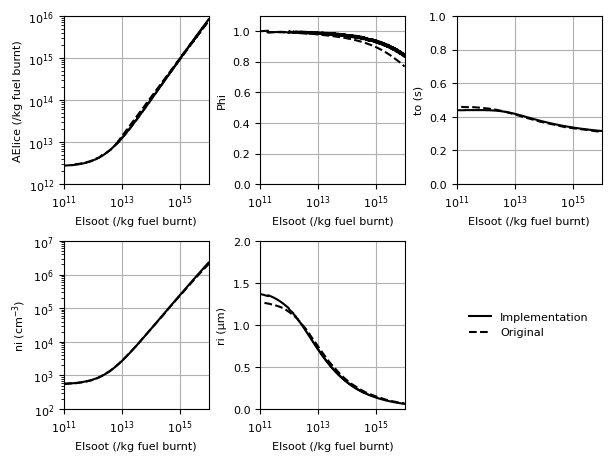

In [ ]:
import pandas as pd 
dfa = pd.read_csv("Datasets/Dataset_a.csv")
dfb = pd.read_csv("Datasets/Dataset_b.csv")
dfc = pd.read_csv("Datasets/Dataset_c.csv")
dfd = pd.read_csv("Datasets/Dataset_d.csv")
dfe = pd.read_csv("Datasets/Dataset_e.csv")
print(dfa.head())

# 2. Create the 2×3 grid of subplots
plt.rcParams['font.size'] = 8
fig1, ax = plt.subplots(2, 3, figsize=(6, 4.5), constrained_layout=True)

# 3. Plot original implementation (solid black) on each populated subplot
ax[0, 0].plot(EIsoot, AEIiceList, label="Implementation", color='k')
ax[0, 0].set_xlabel("EIsoot (/kg fuel burnt)")
ax[0, 0].set_ylabel("AEIice (/kg fuel burnt)")
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
ax[0, 0].set_xlim([10**11, 10**16])
ax[0, 0].set_ylim([10**12, 10**16])

ax[0, 1].plot(EIsoot, PhiList, label="Implementation", color='k')
ax[0, 1].set_xlabel("EIsoot (/kg fuel burnt)")
ax[0, 1].set_ylabel("Phi")
ax[0, 1].set_xscale("log")
ax[0, 1].set_xlim([10**11, 10**16])
ax[0, 1].set_ylim([0, 1.1])

ax[0, 2].plot(EIsoot, toList, label="Implementation", color='k')
ax[0, 2].set_xlabel("EIsoot (/kg fuel burnt)")
ax[0, 2].set_ylabel("to (s)")
ax[0, 2].set_xscale("log")
ax[0, 2].set_xlim([10**11, 10**16])
ax[0, 2].set_ylim([0, 1])

ax[1, 0].plot(EIsoot, noList, label="Implementation", color='k')
ax[1, 0].set_xlabel("EIsoot (/kg fuel burnt)")
ax[1, 0].set_ylabel("ni (cm$^{-3}$)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")
ax[1, 0].set_xlim([10**11, 10**16])
ax[1, 0].set_ylim([10**2, 10**7])

ax[1, 1].plot(EIsoot, riList, label="Implementation", color='k')
ax[1, 1].set_xlabel("EIsoot (/kg fuel burnt)")
ax[1, 1].set_ylabel("ri (µm)")
ax[1, 1].set_xscale("log")
ax[1, 1].set_xlim([10**11, 10**16])
ax[1, 1].set_ylim([0, 2])

# 4. Reserve the bottom-right spot (ax[1, 2]) for the combined legend
ax[1, 2].axis('off')  # turn off axes for the legend panel

# 5. Overlay original-data (dashed black) on each populated subplot
ax[0, 0].plot(dfa.iloc[:, 0], dfa.iloc[:, 1], linestyle='--', color='k', label="Original")
ax[0, 1].plot(dfb.iloc[:, 0], dfb.iloc[:, 1], linestyle='--', color='k', label="Original")
ax[0, 2].plot(dfc.iloc[:, 0], dfc.iloc[:, 1], linestyle='--', color='k', label="Original")
ax[1, 0].plot(dfd.iloc[:, 0], dfd.iloc[:, 1], linestyle='--', color='k', label="Original")
ax[1, 1].plot(dfe.iloc[:, 0], dfe.iloc[:, 1], linestyle='--', color='k', label="Original")

# 6. Enable grid on all populated axes
for i in range(2):
    for j in range(3):
        if (i, j) != (1, 2):
            ax[i, j].grid(True)

# 7. Collect a single legend from the first populated subplot
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[1, 2].legend(handles, labels, loc='center', frameon=False)

plt.show()